# Library

In [1]:
import os
import re
import tensorflow as tf
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Dataset
BBC NEWS 5 Class, >2000 Sample
https://www.kaggle.com/datasets/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data

In [2]:
!wget --no-check-certificate \
https://raw.githubusercontent.com/amirziai/cse6242-project/master/resources/datasets/bbc-text.csv -O /tmp/bbc-text.csv

--2022-10-13 17:40:38--  https://raw.githubusercontent.com/amirziai/cse6242-project/master/resources/datasets/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2022-10-13 17:40:38 (314 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



# Callback
Memberhentikan pembelajaran saat akurasi validation diatas 90%

In [3]:
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_loss')<=0.28 and logs.get('val_accuracy')>=0.90):
      print("Menghentikan proses pembelajaran, Target akurasi sudah tercapai")
      self.model.stop_training=True

myCallback = stopTraining()

# Preprocessing Text
Meliputi


*   Cleaning Unneeded Char (Punct and Number)
*   Filtering Stopwords

*   Stemming and Lemmatization





In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!wget --no-check-certificate \
https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt -O /tmp/more-stopwords.txt

my_file = open("/tmp/more-stopwords.txt")
data = my_file.read()
MORE_STOPWORDS = data.split("\n")

STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(MORE_STOPWORDS)

ps = nltk.stem.PorterStemmer()
ls = nltk.stem.WordNetLemmatizer()

def cleaning_func(text):
    arr=[]
    text = text.lower()
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = text.split()
    for word in text:
      word = ls.lemmatize(word)
      word = ps.stem(word)
      arr.append(word)
    text = ' '.join(arr)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


--2022-10-13 17:40:38--  https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7677 (7.5K) [text/plain]
Saving to: ‘/tmp/more-stopwords.txt’

/tmp/more-stopwords 100%[===================>]   7.50K  --.-KB/s    in 0s      

2022-10-13 17:40:38 (76.9 MB/s) - ‘/tmp/more-stopwords.txt’ saved [7677/7677]



In [5]:
df = pd.read_csv('/tmp/bbc-text.csv')
category = pd.get_dummies(df.category)

df = pd.concat([df,category], axis=1)
df.drop(columns='category', inplace=True, axis=1)

for i in df.index:
  df.at[i,'text']=cleaning_func(df.at[i,'text'])

text_set = df['text']
label_set = df[['business','entertainment','politics','sport','tech']].values

X_train, X_test, y_train, y_test = train_test_split(text_set,
                                                    label_set,
                                                    random_state=1,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

Tokenzing -> Sequences -> Pad_Sequences

In [6]:
tokenizer = Tokenizer(num_words=5000, oov_token='UNK',
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)
tokenizer.fit_on_texts(X_train) 
     
sekuens_latih = tokenizer.texts_to_sequences(X_train)
sekuens_test = tokenizer.texts_to_sequences(X_test)
     
padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

# Model Preparation

In [7]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy']
              )

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 109,701
Trainable params: 109,701
Non-trainable params: 0
_________________________________________________________________


# Fitting Model

In [9]:
num_epochs = 100
records = model.fit(padded_latih, y_train, epochs=num_epochs, batch_size=28, 
                    validation_data=(padded_test, y_test), verbose=2,
                    callbacks=[myCallback])

Epoch 1/100
64/64 - 8s - loss: 1.4801 - accuracy: 0.3657 - val_loss: 1.0534 - val_accuracy: 0.4539 - 8s/epoch - 117ms/step
Epoch 2/100
64/64 - 3s - loss: 1.0043 - accuracy: 0.4539 - val_loss: 0.8966 - val_accuracy: 0.5056 - 3s/epoch - 44ms/step
Epoch 3/100
64/64 - 3s - loss: 0.9358 - accuracy: 0.5427 - val_loss: 0.8912 - val_accuracy: 0.7101 - 3s/epoch - 44ms/step
Epoch 4/100
64/64 - 3s - loss: 0.6397 - accuracy: 0.7511 - val_loss: 0.6231 - val_accuracy: 0.7640 - 3s/epoch - 44ms/step
Epoch 5/100
64/64 - 3s - loss: 0.3751 - accuracy: 0.8809 - val_loss: 0.4584 - val_accuracy: 0.8652 - 3s/epoch - 44ms/step
Epoch 6/100
64/64 - 3s - loss: 0.1682 - accuracy: 0.9551 - val_loss: 0.4088 - val_accuracy: 0.8674 - 3s/epoch - 44ms/step
Epoch 7/100
Menghentikan proses pembelajaran, Target akurasi sudah tercapai
64/64 - 3s - loss: 0.0518 - accuracy: 0.9888 - val_loss: 0.2417 - val_accuracy: 0.9461 - 3s/epoch - 44ms/step


# PLOT ACCURACY and LOSS

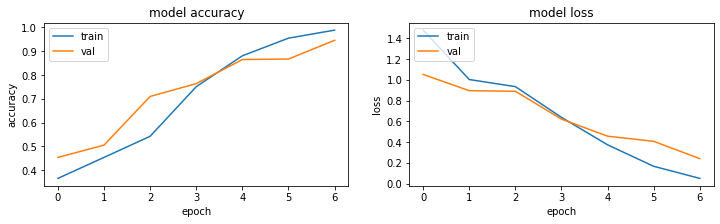

In [10]:
f = plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.plot(records.history['accuracy'])
plt.plot(records.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(records.history['loss'])
plt.plot(records.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()